<a href="https://colab.research.google.com/github/AamnaMirza/Factors-Affecting-Contraceptive-Utilisation-in-India/blob/main/Contraceptives_Utilisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
filename = "NFHS_5_Factsheets_Data_ML.xls"

df = pd.read_excel(filename)
print(f"Successfully loaded data. Shape: {df.shape}")

Successfully loaded data. Shape: (108, 136)


In [3]:
if 'States/UTs' in df.columns:
    df = df[df['States/UTs'] != 'India'].copy()

#Identify Target Variable
target_col = [c for c in df.columns if "Any method" in c and "Current Use" in c]
if target_col:
    target_col = target_col[0]
else:
    raise ValueError("Target column not found.")

df = df.dropna(subset=[target_col])
numeric_cols = df.select_dtypes(include=[np.number]).columns
df[numeric_cols] = df[numeric_cols].map(lambda x: np.nan if x < 0 else x) #Drop Missing Targets

# Drop columns with >40% missing data
df = df.dropna(thresh=int(0.6 * len(df)), axis=1)

#drop features that are >95% correlated with each other to reduce redundancy
feature_df = df.drop(columns=[target_col, 'States/UTs'], errors='ignore').select_dtypes(include=[np.number])
corr_matrix = feature_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

df = df.drop(columns=to_drop)
print(f"Dropped {len(to_drop)} highly correlated features.")
print(f"New Shape: {df.shape}")

Dropped 14 highly correlated features.
New Shape: (107, 122)


In [4]:
X = df.drop(columns=[target_col])
y = df[target_col]

categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [6]:
#lasso
lasso_model = Pipeline(steps=[('preprocessor', preprocessor),
                              ('regressor', Lasso(alpha=0.2, random_state=42))])
lasso_model.fit(X_train, y_train)
y_pred_lasso = lasso_model.predict(X_test)

#random forest
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))])
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

print(f"\nLasso R2: {r2_score(y_test, y_pred_lasso):.4f}")
print(f"Random Forest R2: {r2_score(y_test, y_pred_rf):.4f}")


Lasso R2: 0.9319
Random Forest R2: 0.8512


In [7]:
def get_feature_names(pipeline, num_cols, cat_cols):
    onehot_features = pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_cols)
    return np.concatenate([num_cols, onehot_features])

feature_names = get_feature_names(lasso_model, numerical_cols, categorical_cols)

# Lasso Coefficent
lasso_coefs = lasso_model.named_steps['regressor'].coef_
lasso_df = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(lasso_coefs)})
lasso_df = lasso_df.sort_values(by='Importance', ascending=False).head(10)

# Gini Indec
rf_importances = rf_model.named_steps['regressor'].feature_importances_
rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_df = rf_df.sort_values(by='Importance', ascending=False).head(10)

In [8]:
def get_feature_names(pipeline, num_cols, cat_cols):
    # Helper to get feature names back from the pipeline
    onehot_features = pipeline.named_steps['preprocessor'].transformers_[1][1]['onehot'].get_feature_names_out(cat_cols)
    return np.concatenate([num_cols, onehot_features])

feature_names = get_feature_names(lasso_model, numerical_cols, categorical_cols)
lasso_coefs = lasso_model.named_steps['regressor'].coef_
lasso_df = pd.DataFrame({'Feature': feature_names, 'Importance': np.abs(lasso_coefs)})
lasso_df = lasso_df.sort_values(by='Importance', ascending=False).head(10)
rf_importances = rf_model.named_steps['regressor'].feature_importances_
rf_df = pd.DataFrame({'Feature': feature_names, 'Importance': rf_importances})
rf_df = rf_df.sort_values(by='Importance', ascending=False).head(10)

def truncate_label(text, length=40):
    text = str(text)
    if len(text) > length:
        return text[:length] + "..."
    return text
lasso_df['Feature'] = lasso_df['Feature'].apply(truncate_label)
rf_df['Feature'] = rf_df['Feature'].apply(truncate_label)

/tmp/ipython-input-144359996.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0,0], x='Importance', y='Feature', data=lasso_df, palette='viridis')
/tmp/ipython-input-144359996.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0,1], x='Importance', y='Feature', data=rf_df, palette='magma')


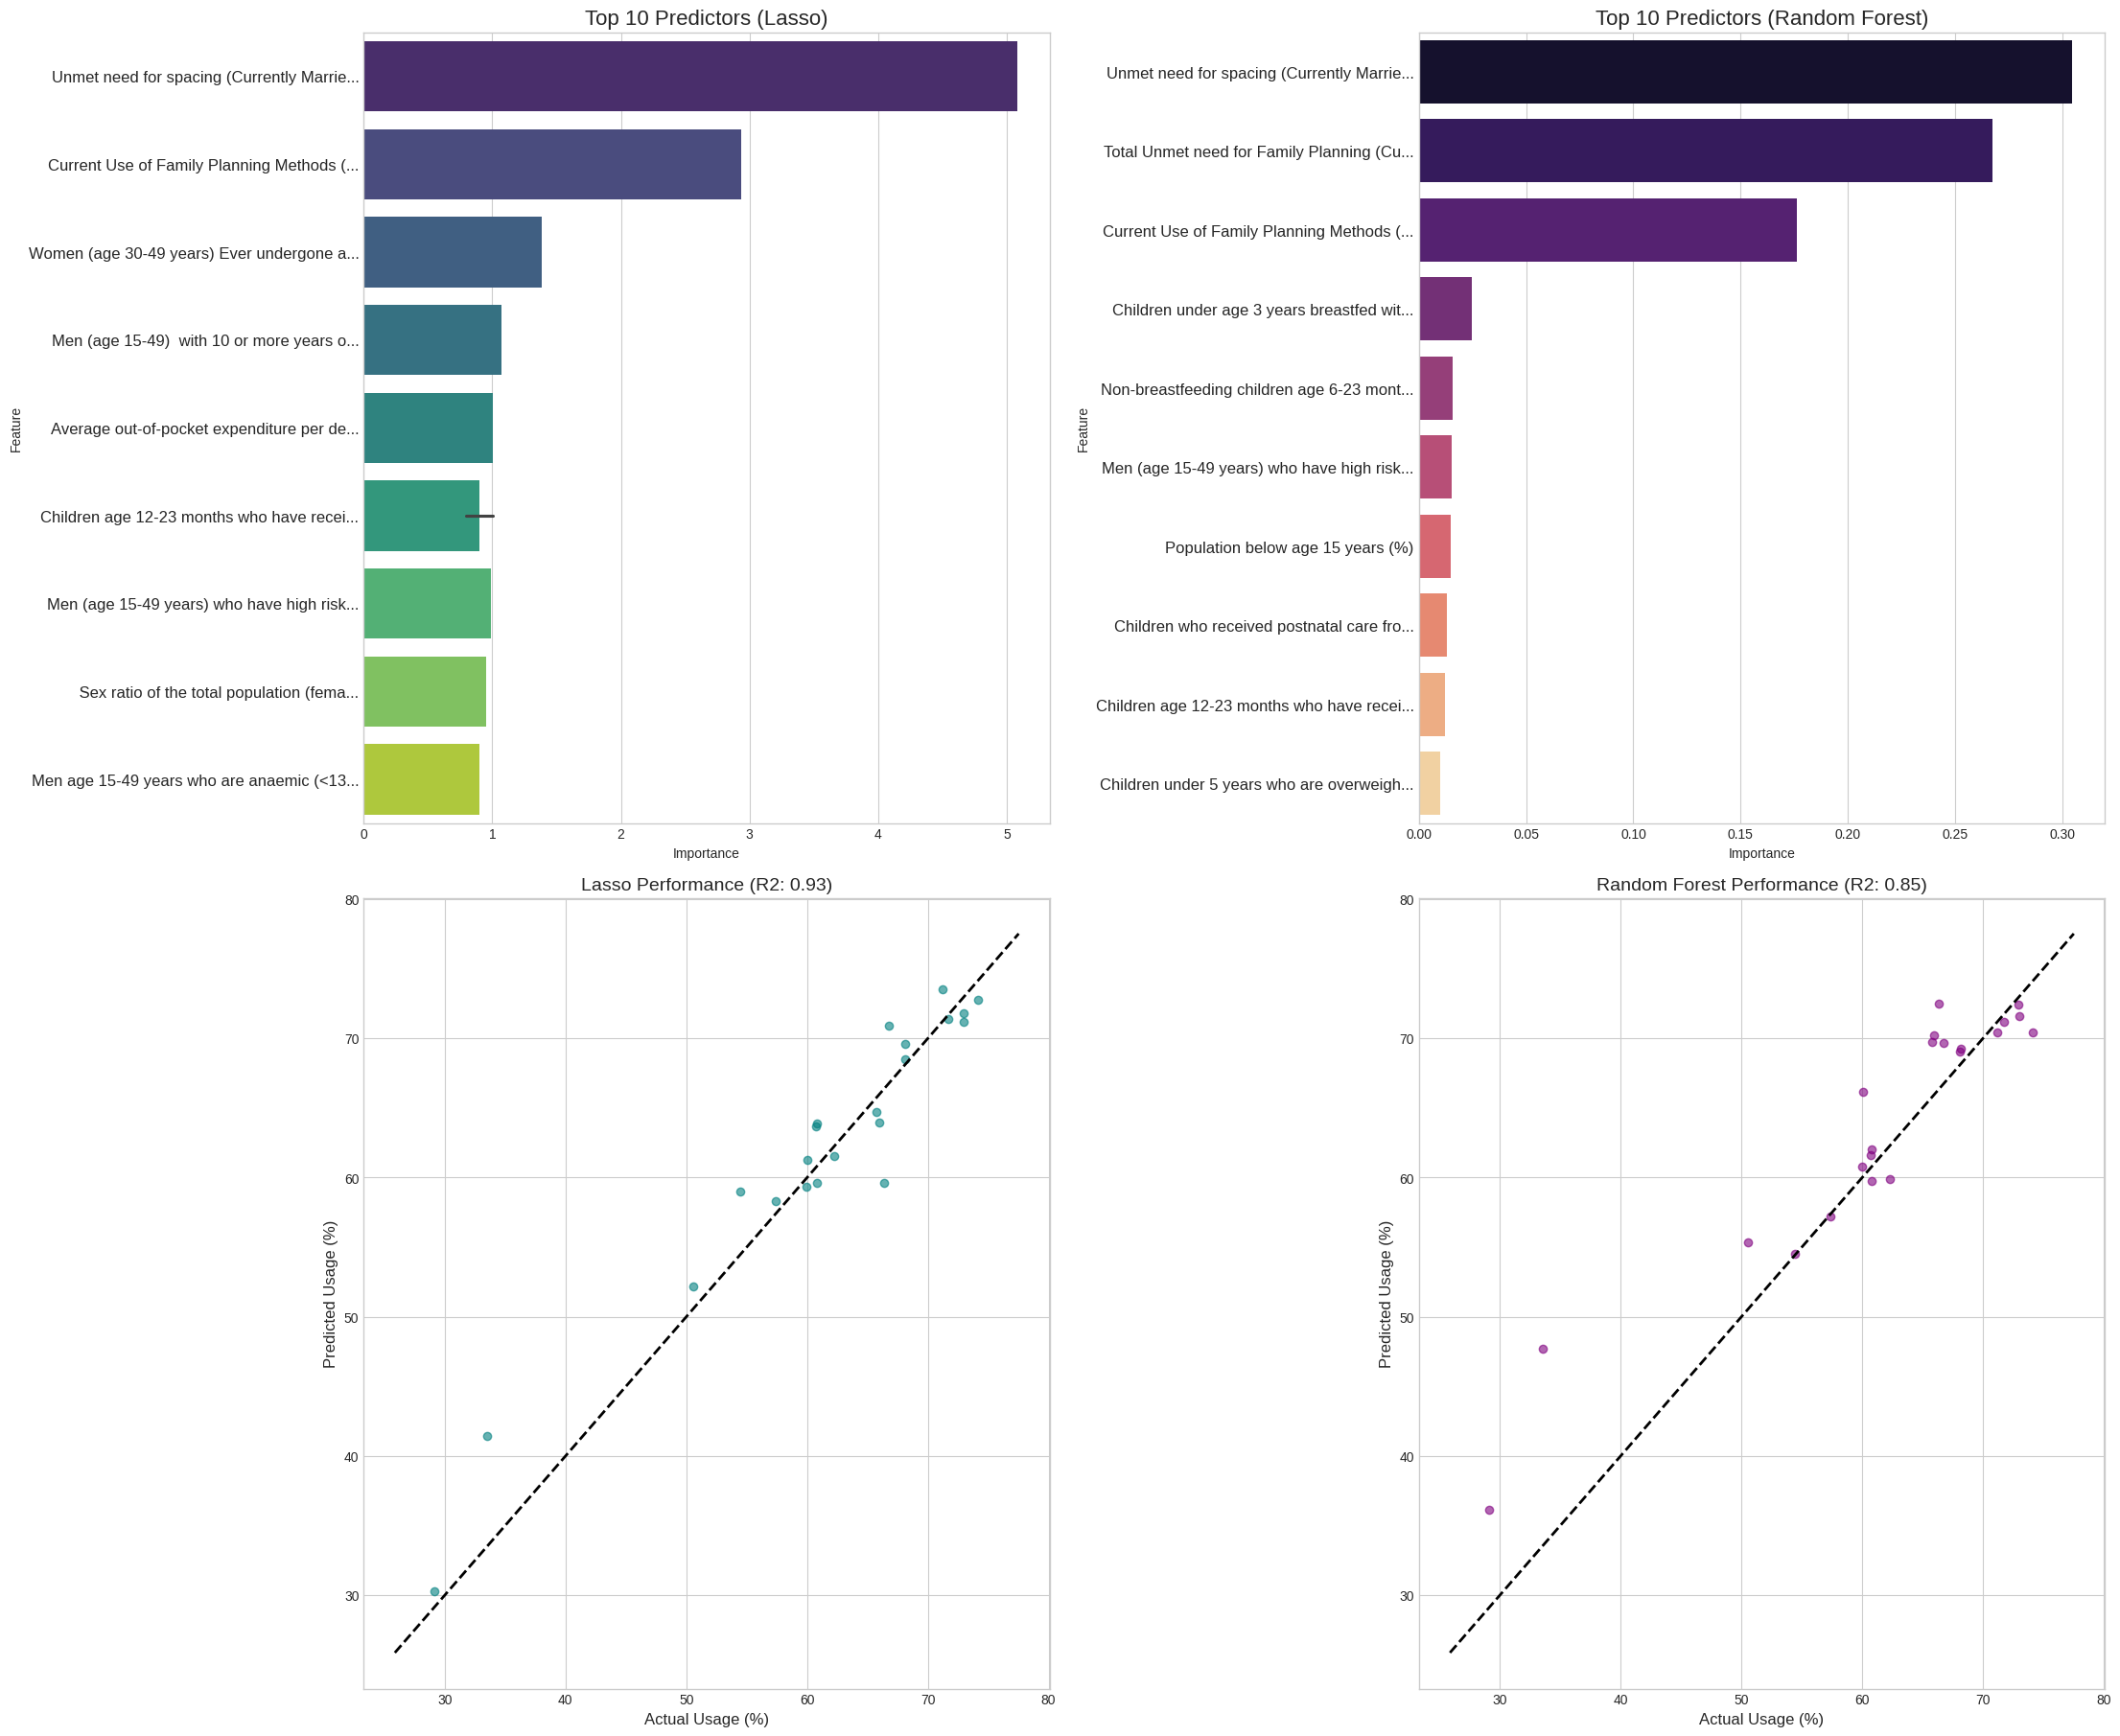

In [9]:
plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(2, 2, figsize=(22, 18), constrained_layout=True)
sns.barplot(ax=axes[0,0], x='Importance', y='Feature', data=lasso_df, palette='viridis')
axes[0,0].set_title('Top 10 Predictors (Lasso)', fontsize=16)
axes[0,0].tick_params(axis='y', labelsize=12) # Readable font size
sns.barplot(ax=axes[0,1], x='Importance', y='Feature', data=rf_df, palette='magma')
axes[0,1].set_title('Top 10 Predictors (Random Forest)', fontsize=16)
axes[0,1].tick_params(axis='y', labelsize=12)
axes[1,0].scatter(y_test, y_pred_lasso, color='teal', alpha=0.6)
axes[1,0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2) # Perfect prediction line
axes[1,0].set_xlabel('Actual Usage (%)', fontsize=12)
axes[1,0].set_ylabel('Predicted Usage (%)', fontsize=12)
axes[1,0].set_title(f'Lasso Performance (R2: {r2_score(y_test, y_pred_lasso):.2f})', fontsize=14)
axes[1,1].scatter(y_test, y_pred_rf, color='purple', alpha=0.6)
axes[1,1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
axes[1,1].set_xlabel('Actual Usage (%)', fontsize=12)
axes[1,1].set_ylabel('Predicted Usage (%)', fontsize=12)
axes[1,1].set_title(f'Random Forest Performance (R2: {r2_score(y_test, y_pred_rf):.2f})', fontsize=14)
plt.show()